# 데이터 준비
- [링크](https://github.com/e9t/nsmc)

In [35]:
import pandas as pd
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더 만들기

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(stopwords) 제거
- 사전 ```word_to_index``` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [36]:
# !pip install konlpy

In [37]:
from konlpy.tag import Okt
import numpy as np
from collections import Counter

tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=30000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [38]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '..': 6,
 '을': 7,
 '...': 8,
 ',': 9,
 '너무': 10,
 '?': 11,
 '다': 12,
 '정말': 13,
 '적': 14,
 '만': 15,
 '진짜': 16,
 '!': 17,
 '로': 18,
 '점': 19,
 '에서': 20,
 '연기': 21,
 '것': 22,
 '평점': 23,
 '내': 24,
 '~': 25,
 '최고': 26,
 '나': 27,
 '그': 28,
 '안': 29,
 '인': 30,
 '이런': 31,
 '스토리': 32,
 '생각': 33,
 '못': 34,
 '....': 35,
 '왜': 36,
 '드라마': 37,
 '게': 38,
 '이다': 39,
 '감동': 40,
 '사람': 41,
 '하는': 42,
 '1': 43,
 '보고': 44,
 '하고': 45,
 '말': 46,
 '고': 47,
 '더': 48,
 '아': 49,
 '때': 50,
 '배우': 51,
 'ㅋㅋ': 52,
 '거': 53,
 '감독': 54,
 '그냥': 55,
 '요': 56,
 '본': 57,
 '내용': 58,
 '재미': 59,
 '중': 60,
 '뭐': 61,
 '까지': 62,
 '!!': 63,
 '보다': 64,
 '없는': 65,
 '시간': 66,
 '수': 67,
 '쓰레기': 68,
 '지': 69,
 '네': 70,
 '봤는데': 71,
 '작품': 72,
 '10': 73,
 '사랑': 74,
 '할': 75,
 '없다': 76,
 '하나': 77,
 '다시': 78,
 '볼': 79,
 '마지막': 80,
 '이건': 81,
 '좋은': 82,
 'ㅋ': 83,
 '저': 84,
 '정도': 85,
 '같은': 86,
 '입니다': 87,
 '완전': 88,
 '있는': 89,
 '2': 90,
 'ㅋㅋㅋ': 91,
 '처음': 92,
 

In [39]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

In [40]:
index_to_word = {index:word for word, index in word_to_index.items()}

## 길이 분포

In [41]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  12.806930515667634
문장길이 최대 :  95
문장길이 표준편차 :  10.399093335789471
pad_sequences maxlen :  33
전체 문장의 0.9347442139050574%가 maxlen 설정값 이내에 포함됩니다. 


<AxesSubplot:ylabel='Density'>

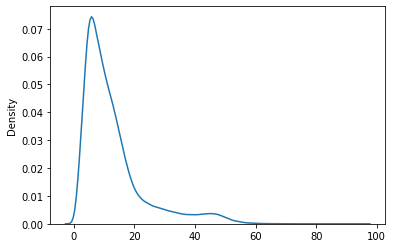

In [42]:
import seaborn as sns
sns.kdeplot(x=num_tokens)

In [43]:
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(\
    X_train,
    value=word_to_index["<PAD>"],
    padding='pre', # 혹은 'post'
    maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(\
    X_test,
    value=word_to_index["<PAD>"],
    padding='pre', # 혹은 'post'
    maxlen=maxlen)

# 모덷 구성 및 validation

In [44]:
vocab_size = 1000    # 어휘 사전의 크기입니다(1000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [45]:
# validation set 50000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 96182건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 33)
(96182,)


In [46]:
import tensorflow as tf
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 200)         200000    
                                                                 
 lstm_1 (LSTM)               (None, 8)                 6688      
                                                                 
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 206,769
Trainable params: 206,769
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D())
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 200)         200000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          22416     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 8)                

In [48]:
model_max_pooling = tf.keras.Sequential()
model_max_pooling.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max_pooling.add(tf.keras.layers.GlobalMaxPooling1D())
model_max_pooling.add(tf.keras.layers.Dense(8, activation='relu'))
model_max_pooling.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_max_pooling.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 200)         200000    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 8)                 1608      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 201,617
Trainable params: 201,617
Non-trainable params: 0
_________________________________________________________________


In [49]:
models = [model_rnn, model_cnn, model_max_pooling]

# 모델 훈련 개시

In [50]:
historys = []
for model in models:
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
                
    epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

    historys.append(model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1))

Epoch 1/20
188/188 [==============================] - 14s 60ms/step - loss: 0.5262 - accuracy: 0.7452 - val_loss: 0.4485 - val_accuracy: 0.7823
Epoch 2/20
188/188 [==============================] - 9s 50ms/step - loss: 0.4374 - accuracy: 0.7887 - val_loss: 0.4324 - val_accuracy: 0.7904
Epoch 3/20
188/188 [==============================] - 11s 56ms/step - loss: 0.4270 - accuracy: 0.7937 - val_loss: 0.4300 - val_accuracy: 0.7892
Epoch 4/20
188/188 [==============================] - 10s 56ms/step - loss: 0.4209 - accuracy: 0.7958 - val_loss: 0.4242 - val_accuracy: 0.7945
Epoch 5/20
188/188 [==============================] - 12s 63ms/step - loss: 0.4143 - accuracy: 0.7983 - val_loss: 0.4243 - val_accuracy: 0.7934
Epoch 6/20
188/188 [==============================] - 11s 58ms/step - loss: 0.4087 - accuracy: 0.8011 - val_loss: 0.4235 - val_accuracy: 0.7932
Epoch 7/20
188/188 [==============================] - 10s 55ms/step - loss: 0.4038 - accuracy: 0.8027 - val_loss: 0.4211 - val_accuracy: 

In [51]:
history_dicts = []
for history in historys:
    history_dicts.append(history.history)

# Loss Accuarcy

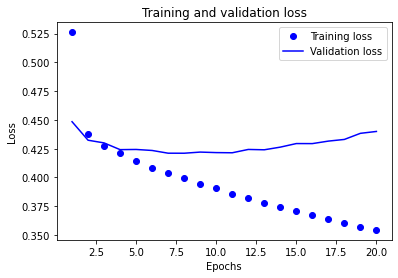

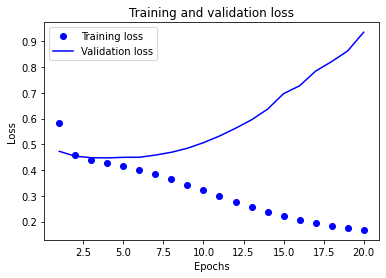

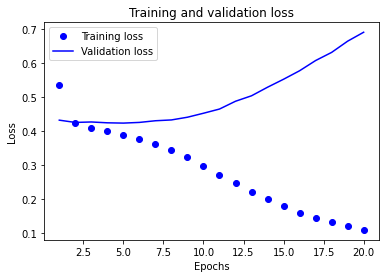

In [52]:
import matplotlib.pyplot as plt
for history_dict in history_dicts:
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 학습된 Embedding 레이어 분석

In [53]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'text/result.txt'
f = open(word2vec_file_path, 'w', encoding='UTF-8')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("영화")

[('.', 0.7142196297645569),
 (',', 0.656861424446106),
 ('중', 0.6349111199378967),
 ('..', 0.6330218315124512),
 ('너무', 0.6249079704284668),
 ('완전', 0.6227236986160278),
 ('...', 0.6208988428115845),
 ('임', 0.6043570637702942),
 ('인', 0.6022415161132812),
 ('이런', 0.601402223110199)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [74]:
from gensim.models import Word2Vec
word2vec_path = 'data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
word2vec.similar_by_word("영화")

C:\Users\Byeongryul\AppData\Local\Temp\ipykernel_12464\272575666.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("영화")


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

In [75]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

C:\Users\Byeongryul\AppData\Local\Temp\ipykernel_12464\1390784066.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
C:\Users\Byeongryul\AppData\Local\Temp\ipykernel_12464\1390784066.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [77]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(\
    vocab_size, 
    word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen, 
    trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 33, 200)           200000    
                                                                 
 conv1d_6 (Conv1D)           (None, 27, 16)            22416     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 13, 16)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 7, 16)             1808      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 8)                

In [79]:
# 학습의 진행
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(
    partial_X_train,
    partial_y_train,
    epochs=epochs,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1)

Epoch 1/10
376/376 [==============================] - 20s 51ms/step - loss: 0.4707 - accuracy: 0.7654 - val_loss: 0.4752 - val_accuracy: 0.7621
Epoch 2/10
376/376 [==============================] - 18s 49ms/step - loss: 0.4458 - accuracy: 0.7785 - val_loss: 0.4677 - val_accuracy: 0.7639
Epoch 3/10
376/376 [==============================] - 19s 51ms/step - loss: 0.4317 - accuracy: 0.7871 - val_loss: 0.4829 - val_accuracy: 0.7535
Epoch 4/10
376/376 [==============================] - 17s 46ms/step - loss: 0.4209 - accuracy: 0.7933 - val_loss: 0.4675 - val_accuracy: 0.7639
Epoch 5/10
376/376 [==============================] - 17s 45ms/step - loss: 0.4088 - accuracy: 0.7999 - val_loss: 0.4769 - val_accuracy: 0.7600
Epoch 6/10
376/376 [==============================] - 18s 47ms/step - loss: 0.3959 - accuracy: 0.8079 - val_loss: 0.4785 - val_accuracy: 0.7626
Epoch 7/10
376/376 [==============================] - 17s 45ms/step - loss: 0.3842 - accuracy: 0.8141 - val_loss: 0.4856 - val_accuracy:

In [80]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5358 - accuracy: 0.7493 - 4s/epoch - 3ms/step
[0.5358126163482666, 0.7492727637290955]
